In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker
from gammapy.irf import EDispKernel
from gammapy.makers.utils import make_psf_map
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)

0.20.1


In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [3]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.geomspace(0.5,100,40) # a fine binning in true energy
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.01,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [4]:
%%time
maker = MapDatasetMaker(selection=["counts", 'exposure','edisp', 'background', 'psf'])
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)

dataset = maker.run(reference, obs1)

CPU times: user 3.24 s, sys: 750 ms, total: 3.99 s
Wall time: 4.02 s


In [5]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab

dataset.exposure.quantity = 1. * dataset.exposure.unit # for comparison neglect exposure here
dataset.models=[model_gauss]

In [6]:
# define a mask safe which cuts from the model in space and energy
mask_safe = dataset.counts.copy()
mask_safe.data = True
coords_ms = mask_safe.geom.get_coord(sparse=True)
sep = coords_ms.skycoord.separation(obs_pos)
mask_safe.data *= sep < .6 * u.deg
e_mask=mask_safe.geom.energy_mask(1*u.TeV, 30*u.TeV)
mask_safe.data *= e_mask
dataset.mask_safe = mask_safe

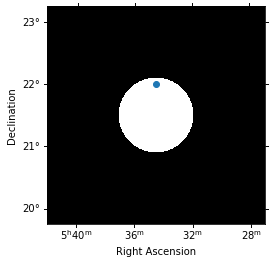

In [7]:
dataset.mask_safe.sum_over_axes().plot()
ax=plt.gca()
plt.scatter(model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, transform=ax.get_transform('world'))

In [8]:
# define geometry with different binning compared to mask_safe
ebins_model = np.geomspace(0.5,100,40) 
energy_axis_model = MapAxis.from_edges(
    ebins_model, unit="TeV", name="energy_true", interp="log"  
)
geom_model = WcsGeom.create(
    skydir=crab_pos,
    binsz=0.01,
    width=(0.5, 0.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis_model],
)
geom_model_mask = geom_model.to_image().to_cube([mask_safe.geom.axes['energy']])
coords_model = geom_model_mask.get_coord()  # or take the coords directly if coords are passed
mask_model = Map.from_geom(geom=geom_model_mask.as_energy_true, 
                           data=mask_safe.interp_by_coord(coords_model))

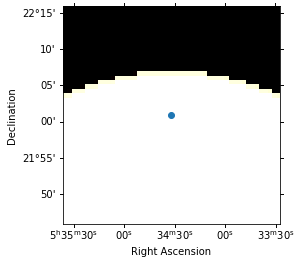

In [9]:
# look at the interpolated mask
# pixels on the edge of mask_safe will get fractional values
mask_model.sum_over_axes().plot()
ax=plt.gca()
plt.scatter(model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, transform=ax.get_transform('world'))

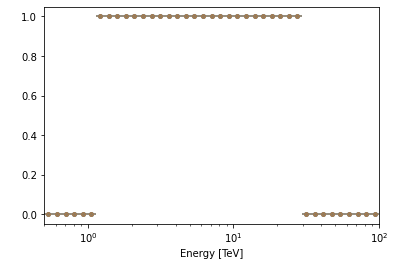

In [10]:
# the same happens in energy if we choose different energy binning
# but the edisp will also handle this so we stick to the same energy binning for now
mask_model.get_spectrum(region=crab_pos).plot()
mask_safe.get_spectrum(region=crab_pos).plot(alpha=0.5)
plt.yscale("linear")

## closer look at the psf values

In [97]:
psf= obs1.psf
pointing=obs_pos
model_pos = model_gauss.position
geom_psf = mask_safe.geom.to_image().cutout(model_pos, mask_safe.geom.pixel_scales*3)
geom_psf = geom_psf.to_cube([psf.axes['rad'], geom_model.axes['energy_true']])
psfmap = make_psf_map(psf, pointing, geom_psf)
# now get the kernel at the model position
psf_kernel = psfmap.get_psf_kernel(geom_model, position=model_pos)

In [98]:
pos_fake = model_pos.directional_offset_by(-100*u.deg, 0.015*u.deg)
psf_kernel2 = psfmap.get_psf_kernel(geom_model, position=pos_fake)

print(pos_fake.separation(pointing).deg)
print(model_pos.separation(pointing).deg)

0.5118174843714088
0.5006313141641109


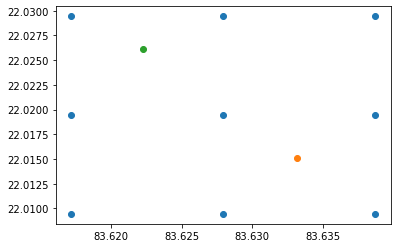

In [99]:
coords_psf=geom_psf.get_coord(sparse=True)
plt.plot(coords_psf['lon'].flatten(), coords_psf['lat'].flatten(), 'o')
plt.plot(model_pos.icrs.ra.deg, model_pos.icrs.dec.deg, 'o')
plt.plot(pos_fake.icrs.ra.deg, pos_fake.icrs.dec.deg, 'o')

In [100]:
np.all(np.isclose(psf_kernel.data, psf_kernel2.data, rtol=1e-1, atol=0),axis=(1,2))

array([False, False,  True,  True,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True, False,  True, False, False, False,
       False, False, False])

(array([1.76000e+02, 7.41800e+03, 6.81865e+05, 2.26000e+02, 5.60000e+01,
        3.20000e+01, 2.50000e+01, 1.70000e+01, 9.00000e+00, 1.20000e+01,
        4.00000e+00, 9.00000e+00, 4.00000e+00, 8.00000e+00, 0.00000e+00,
        5.00000e+00, 0.00000e+00, 4.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-2.66414169e-05, -1.38414804e-05, -1.04154381e-06,  1.17583927e-05,
         2.45583293e-05,  3.73582659e-05,  5.01582024e-05,  6.29581390e-05,
         7.57580755e-05,  8.85580121e-05,  1.01357949e-04,  1.14157885e-04,
         1.26957822e-04,  1.39757758e-04,  1.52557695e-04,  1.65357631e-04,
         1.78157568e-04,  1.90957505e-04,  2.03757441e-04,  2.16557378e-04,
         2.29357314e-04]),
 <BarContainer object of 20 artists>)

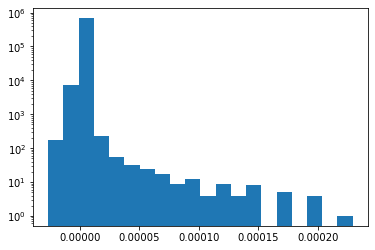

In [101]:
diff = (psf_kernel.data - psf_kernel2.data)#/psf_kernel.data
# diff[np.abs(diff)>1]=0
plt.hist(np.nan_to_num(diff.flatten()), bins=20, log=True)

### however the psfs look very similar

In [102]:
dataset.npred()
ev=dataset.evaluators['crab_model_gauss']

In [103]:
ev.psf.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [104]:
psf_kernel.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [105]:
psf_kernel2.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

## test the function

In [10]:
def make_acceptance(mask_safe, edisp, psf, model_pos, pointing, geom_model):
    """It will be model specific. 
    offset = offset of model_pos and pointing (same as is used for binned)
    geom_model = geom on which the model is evaluated, maybe we want to pass coords instead
    a new mask needs to be interpolated from the mask safe on the geom
    """
    offset = model_pos.separation(pointing)
    ## get the new mask_safe based on the geometry on which the model is evaluated
    geom_model_mask = geom_model.to_image().to_cube([mask_safe.geom.axes['energy']])
    coords_model = geom_model_mask.get_coord()  # or take the coords directly if coords are passed
    # the mask_safe in model geometry
    mask_model = Map.from_geom(geom=geom_model_mask.as_energy_true, 
                               data=mask_safe.interp_by_coord(coords_model))
    
    ## create edisp 
    # because we want to convolve a reco map we do a trick and create a transposed EdispKernel
    edisp_kernel = edisp.to_edisp_kernel(offset, 
                                         energy_true=geom_model.axes['energy_true'].edges , 
                                         energy=mask_safe.geom.axes['energy'].edges)
    # change the axes
    ax_reco = geom_model.axes['energy_true'].copy()
    ax_true = mask_safe.geom.axes['energy'].copy()
    ax_reco._name="energy"
    ax_true._name='energy_true'
    edisp_kernelT = EDispKernel(axes=[ax_true, ax_reco], data = edisp_kernel.data.T)
    
    ## create the psf
    # first a PSFMap with 3x3 pixels around the model_position
    geom_psf = mask_safe.geom.to_image().cutout(model_pos, mask_safe.geom.pixel_scales*3)
    geom_psf = geom_psf.to_cube([psf.axes['rad'], geom_model.axes['energy_true']])
    psfmap = make_psf_map(psf, pointing, geom_psf)
    # now get the kernel at the model position
    psf_kernel = psfmap.get_psf_kernel(geom_model, position=model_pos)

    acceptance=mask_model.apply_edisp(edisp_kernelT)  # order of edisp and psf doesn't matter much
    return acceptance.convolve(psf_kernel) # but edisp does ereco --> etrue and psf is in etrue

In [11]:
%%time
# When using the geom_model for the model evaluation
acceptance=make_acceptance(mask_safe, obs1.edisp, obs1.psf, model_gauss.position, obs_pos, geom_model)

CPU times: user 5.31 s, sys: 1.78 s, total: 7.09 s
Wall time: 7.11 s


In [12]:
# %%time
# When using the mask_safe.geom for the model evaluation
acceptance=make_acceptance(mask_safe, obs1.edisp, obs1.psf, model_gauss.position, obs_pos, mask_safe.geom.as_energy_true)

In [13]:
# the acceptance is the interpolated mask_safe smoothed with the irfs
acceptance.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [86]:
# get both the total npred in true coordinates and the amount that falls into the reco mask_safe
npred_true=model_gauss.integrate_geom(geom_model)
npred_sum = np.sum(npred_true.quantity.to_value("s-1 m-2") * acceptance.data)
print(npred_sum)
print(npred_true.quantity.to_value("s-1 m-2").sum())

2.3977646581555372e-08
5.733697816914333e-08


In [87]:
# compare to the total npred in reco coordinates and the amount that falls into the reco mask_safe
npred_ds = dataset.npred()  # also contains background
npred_ds.data = 0.
npred_source=dataset.evaluators['crab_model_gauss'].compute_npred()
npred_ds.stack(npred_source) # we need the full map geometry to apply the safe mask
print(npred_ds.data[mask_safe.data].sum())
print(npred_ds.data.sum())

2.397609347982785e-08
5.702710049135778e-08


In [88]:
ev=dataset.evaluators['crab_model_gauss']
ev.apply_exposure(ev.compute_flux_psf_convolved()).data.sum()

5.7336977544395905e-08

In [106]:
# npred_true=model_gauss.integrate_geom(ev.exposure.geom)
# npred_sum = np.sum(npred_true.quantity.to_value("s-1 m-2") * acceptance.data)
# print(npred_sum)
# print(npred_true.quantity.to_value("s-1 m-2").sum())

In [89]:
ratio_binned=[]
ratio_unbinned=[]
ratio_both=[]
alphas=np.linspace(0.5,3.5,10)
for alpha in alphas:
    model_gauss.spectral_model.alpha.value = alpha
    
#     npred_true=model_gauss.integrate_geom(mask_safe.geom.as_energy_true)
    npred_true=model_gauss.integrate_geom(geom_model)
    npred_sum = np.sum(npred_true.quantity.to_value("s-1 m-2") * acceptance.data)
    usm=npred_sum
    us=npred_true.quantity.to_value("s-1 m-2").sum()
    ratio_unbinned.append(usm/us)
    
    npred_ds = dataset.npred()  # also contains background
    npred_ds.data = 0.
    npred_source=dataset.evaluators['crab_model_gauss'].compute_npred()
    npred_ds.stack(npred_source) # we need the full map geometry to apply the safe mask
    sbm=npred_ds.data[mask_safe.data].sum()
    sb=npred_ds.data.sum()
    ratio_binned.append(sbm/sb)
    
    ratio_both.append(usm/sbm)

Text(0.5, 0, 'spectral index')

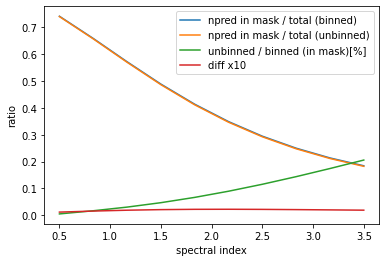

In [94]:
# with mask_safe.geom for the model
plt.plot(alphas, ratio_binned, label='npred in mask / total (binned)')
plt.plot(alphas, ratio_unbinned, label='npred in mask / total (unbinned)')
plt.plot(alphas, (np.array(ratio_both)-1)*1000, label='unbinned / binned (in mask)[%]')
plt.plot(alphas, (np.array(ratio_binned)-ratio_unbinned)*10, label='diff x10')
plt.legend()
plt.ylabel('ratio')
plt.xlabel('spectral index')

Text(0.5, 0, 'spectral index')

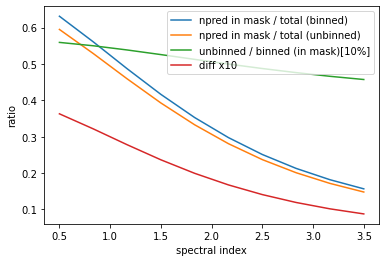

In [43]:
# with geom_model
plt.plot(alphas, ratio_binned, label='npred in mask / total (binned)')
plt.plot(alphas, ratio_unbinned, label='npred in mask / total (unbinned)')
plt.plot(alphas, (np.array(ratio_both)-1)*-10, label='unbinned / binned (in mask)[10%]')
plt.plot(alphas, (np.array(ratio_binned)-ratio_unbinned)*10, label='diff x10')
plt.legend()
plt.ylabel('ratio')
plt.xlabel('spectral index')

# Conclusion
We see nearly perfect agreement (<0.4%) if the model_geometry is the same as the mask_safe geometry. Otherwise the acceptance gives ~ 6% less of the counts compared to the application of mask_safe.

We improve a little to 5.5% when using the same energy axis.
A similar amount when choosing the same pixels and also when both are equal

We improve up to 3% when the geometries are alligned, i.e. also using obs_pos as center and the same pixel size

TODO: Check if Edisp is the reason for bad performance with different energy axes by enabling and disabling the edisp  
    -> the edisp has only a very minor influence on the difference
 
But the psf has a large influence. By disabling the psf we get almost perfect agreement.  
Also if the source in not near the mask's edge the influence of the PSF is small.  
The exact position of the interpolation of the `PSFMap` to the `PSFKernel` seems to have a rather large influence on the exact values of the kernel.